# Capstone 2: Modeling

### 1. Sourcing and Loading

#### 1a. Import Relevant Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from library.sb_utils import save_file

#### 1b. Load the Data

In [2]:
import hickle as hkl

In [3]:
data = hkl.load("stroke_traintest_unscaled_data.hkl")

In [4]:
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

In [5]:
# make sure the X data looks correct
X_train.head()

,gender,ever_married,Residence_type,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,id,hypertension,heart_disease,avg_glucose_level,bmi
2331,1,1,0,0,0,1,0,0,0,1,0,0,15351,0,0,91.68,32.4
3901,1,1,1,0,0,1,0,0,0,0,1,0,37479,0,0,93.96,33.3
1436,1,1,0,1,0,0,0,0,0,1,0,0,71318,0,0,244.28,29.4
1018,0,1,0,0,0,0,1,0,1,0,0,0,17437,0,0,85.60,25.9
3567,0,1,0,0,0,0,1,0,0,0,1,0,62475,1,0,88.18,33.5


In [6]:
# remove ID columns for modeling
X_train_id = X_train['id']
X_train = X_train.drop(['id'], axis=1)

X_test_id = X_test['id']
X_test = X_test.drop(['id'], axis=1)

X_train.columns

Index(['gender', 'ever_married', 'Residence_type', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes', 'hypertension',
       'heart_disease', 'avg_glucose_level', 'bmi'],
      dtype='object')

In [7]:
# make sure the y data is there
y_train.head()

2331    0
3901    0
1436    0
1018    0
3567    0
Name: stroke, dtype: int64

In [8]:
# verify data set shapes
print("X_train shape: " + str(X_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_train shape: " + str(y_train.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (4086, 16)
X_test shape: (1022, 16)
y_train shape: (4086,)
y_test shape: (1022,)


### 2. Create Baseline Models

Now, we can select a few algorithms and create baseline models. In these models, we want to keep things fairly simple and strive to select one or two algorithms to move forward with. Once we select the best models, we can do further parameter testing and try to optimize the performance. Speaking of performance, we will look at the ROC curves for the baseline models to determine their performace. Furthermore, reducing false-negative predictions (predicting non-stroke when actually stroke) is very important in healthcare datasets such as these where the predictions could lead to missing a diagnosis. 

The models that will be tested here are a random forest classifier, support vector machine, logistic regression, XGBoost, and CatBoost.

#### 2a. Random Forest Classifier

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

In [10]:
# create grid search and fit model
params = {'n_estimators':[50, 100, 200, 300], 'max_depth':[3,7,20], 'min_samples_split':[2,4,10]}
rfc = RandomForestClassifier()
#rfc_cv = GridSearchCV(rfc, params, scoring='recall', cv=5)
rfc_cv = GridSearchCV(rfc, params, scoring='f1', cv=10)
rfc_cv.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 7, 20],
                         'min_samples_split': [2, 4, 10],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='f1')

In [11]:
# print best parameters
print("Best Parameters: " + str(rfc_cv.best_params_))

Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


In [12]:
# create model with best parameters
rfc = RandomForestClassifier(max_depth=20, min_samples_split=2, n_estimators=200)
rfc.fit(X_train, y_train)
y_train_pred = rfc.predict(X_train)
y_test_pred = rfc.predict(X_test)

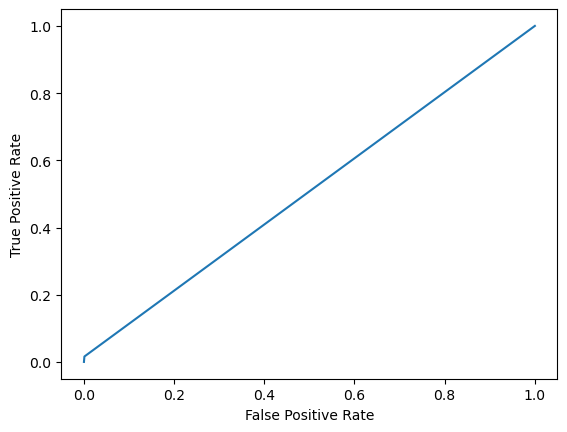

AUC score: 0.5075436827956988


In [13]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_pred)))

In [14]:
# print confusion matrix
confusion_matrix(y_test, y_test_pred)

array([[959,   1],
       [ 61,   1]], dtype=int64)

As we can see from the ROC curve and the confusion matrix, this classifier did a bad job at distinguishing the classes. This model has zero recall, meaning it predicted all observations to be '0'.

#### 2b. Support Vector Machine

In [15]:
from sklearn.svm import SVC

In [16]:
# create grid search and fit model
params = {'C':[0.1, 1, 10, 100, 1000], 'gamma':['auto'], 'kernel':['rbf']}
svc = SVC()
svc_cv = GridSearchCV(svc, params, scoring='recall', cv=5)
svc_cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000], 'gamma': ['auto'],
                         'kernel': ['rbf']},
             scoring='recall')

In [17]:
# print best parameters
print("Best Parameters: " + str(svc_cv.best_params_))

Best Parameters: {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}


In [18]:
# create model with best parameters
svc = SVC(C=1000, gamma='auto', kernel='rbf')
svc.fit(X_train, y_train)
y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)

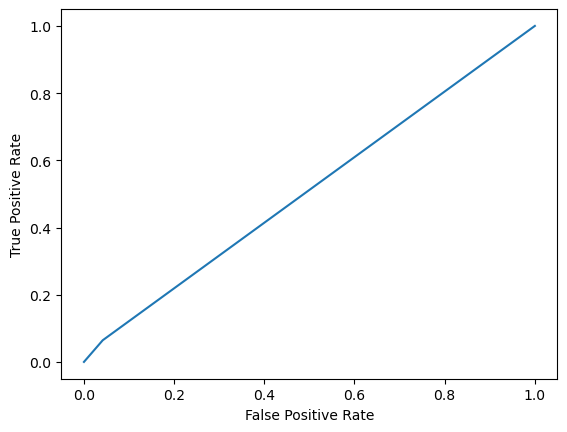

AUC score: 0.5114247311827957


In [19]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_pred)))

In [20]:
# print confusion matrix
confusion_matrix(y_test, y_test_pred)

array([[920,  40],
       [ 58,   4]], dtype=int64)

The same thing happened again: all 62 stroke events were predicted to be non-strokes. This is a problem and a useless model for our goal. We will keep trying to find another model that can distinguish the two classes.

#### 2c. Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression

In [22]:
# create grid search and fit model
params = {'penalty':['none', 'l1', 'l2'], 'C':[0.1, 1, 10, 100, 1000]}
logr = LogisticRegression()
logr_cv = GridSearchCV(logr, params, scoring='recall', cv=5)
logr_cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'penalty': ['none', 'l1', 'l2']},
             scoring='recall')

In [23]:
# print best parameters
print("Best Parameters: " + str(logr_cv.best_params_))

Best Parameters: {'C': 0.1, 'penalty': 'none'}


In [24]:
# create model with best parameters
logr = LogisticRegression(C=0.1, penalty='none')
logr.fit(X_train, y_train)
y_train_pred = logr.predict(X_train)
y_test_pred = logr.predict(X_test)

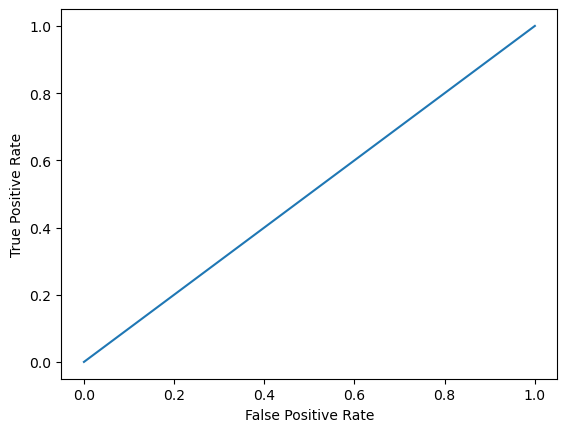

AUC score: 0.5


In [25]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_pred)))

In [26]:
# print confusion matrix
confusion_matrix(y_test, y_test_pred)

array([[960,   0],
       [ 62,   0]], dtype=int64)

Same results...

#### 2d. XGBoost

In [65]:
! pip install xgboost

     ---------------------------------------- 70.9/70.9 MB 1.7 MB/s eta 0:00:00


In [27]:
from xgboost import XGBClassifier

In [28]:
# train general XGBoost classifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [29]:
# predict on training and testing sets
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

y_train_pred = [round(value) for value in y_train_pred]
y_test_pred = [round(value) for value in y_test_pred]

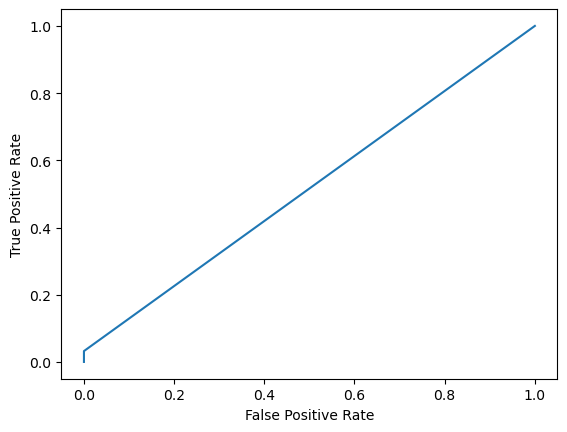

AUC score: 0.5161290322580645


In [30]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_pred)))

In [31]:
# print confusion matrix
confusion_matrix(y_test, y_test_pred)

array([[960,   0],
       [ 60,   2]], dtype=int64)

This model predicted 2 stroke victims correctly, and predicted 4 incorrectly. This is better than a recall of zero but needs much improvement to be a sensible model.

#### 2e. CatBoost

In [71]:
! pip install catboost

In [32]:
from catboost import CatBoostClassifier

In [ ]:
# create grid search and fit model
params = {'depth':[4,6,8,10], 'learning_rate':[0.01, 0.05, 0.1], 'iterations':[10, 50, 100]}
cbc = CatBoostClassifier()
cbc_cv = GridSearchCV(cbc, params, scoring='recall', cv=5)
cbc_cv.fit(X_train,y_train, silent=True)

In [34]:
# print best parameters
print("Best Parameters: " + str(cbc_cv.best_params_))

Best Parameters: {'depth': 8, 'iterations': 100, 'learning_rate': 0.1}


In [35]:
# create model with best parameters
cbc = CatBoostClassifier(depth=8, iterations=100, learning_rate=0.1)
cbc.fit(X_train, y_train)
y_train_pred = cbc.predict(X_train)
y_test_pred = cbc.predict(X_test)

0:	learn: 0.6226812	total: 12.5ms	remaining: 1.24s
1:	learn: 0.5589803	total: 20.9ms	remaining: 1.02s
2:	learn: 0.5071681	total: 32.5ms	remaining: 1.05s
3:	learn: 0.4638528	total: 37.5ms	remaining: 900ms
4:	learn: 0.4254875	total: 42.4ms	remaining: 805ms
5:	learn: 0.3967243	total: 49.9ms	remaining: 781ms
6:	learn: 0.3672175	total: 51.5ms	remaining: 684ms
7:	learn: 0.3425251	total: 53.5ms	remaining: 616ms
8:	learn: 0.3233125	total: 58.5ms	remaining: 592ms
9:	learn: 0.3051313	total: 64ms	remaining: 576ms
10:	learn: 0.2883300	total: 68.8ms	remaining: 557ms
11:	learn: 0.2755033	total: 74ms	remaining: 542ms
12:	learn: 0.2638001	total: 79.3ms	remaining: 531ms
13:	learn: 0.2530512	total: 84.2ms	remaining: 517ms
14:	learn: 0.2441696	total: 89.2ms	remaining: 505ms
15:	learn: 0.2362319	total: 94.3ms	remaining: 495ms
16:	learn: 0.2288828	total: 99.1ms	remaining: 484ms
17:	learn: 0.2223294	total: 104ms	remaining: 473ms
18:	learn: 0.2160109	total: 109ms	remaining: 464ms
19:	learn: 0.2109754	total: 

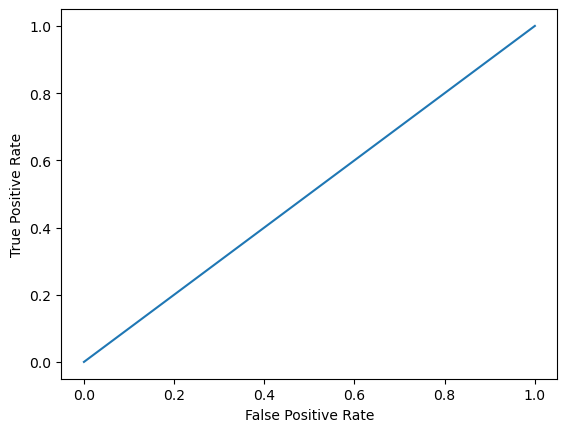

AUC score: 0.5


In [36]:
# generate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("AUC score: " + str(roc_auc_score(y_test, y_test_pred)))

In [37]:
# print confusion matrix
confusion_matrix(y_test, y_test_pred)

array([[960,   0],
       [ 62,   0]], dtype=int64)